# Dependency Graph Test Strategy Analysis

The following notebook analyzes test results from the experimental `dependency_graph` Azure pipeline. 

Using `script.py`, I've gone ahead and accessed the Azure API to retrieve all logs and parse any relevant details. These results are saved to `azure_runs.csv` and are analyzed in the below cells. 

Some minor details to note:
* The starting date for this experiment is 12/13/2021 and should cover all data up until the current date.
* I've only set up a few stages in the experimental pipeline (no usage stats and isolated to just 3.8). This was to ensure that we didn't use up too many resources and adversely impact developers.
* There have been 2 real deviations - any descrepancies have been manually reviewed and can be `deviations.csv`.
  - It seems that the `dgtest` algorithm doesn't work super well with CFE JSON-file parameterized tests (at least in its current state)
  - The algorithm has had a variety of false positives due to usage stats failure, checkout errors, and shared state between tests. These are not considered true deviations as they aren't the result of the `dgtest` algorithm.
* The `test_cli` stage is conditionally run based on the other stages; as such, it will run less often than the rest of the pipeline.
* The `depth` argument is set at `3`. I think there's a noticable drop in coverage when you go down to `2` and I'm not sure `4` is necessary since we've been able to mirror the results of the primary pipeline.

---

**Conclusion**: I think this test was a success. The sample size is quite small but the fact that the dependency graph test strategy always aligned with our current strategy shows that we can test a subset of our suite without sacrificing accuracy or coverage. 

**Next Steps**:
* ~Gather a bit more data~
* ~Move this logic to a separate repo/package~
* ~Add tests~
* Set up automated full-suite runs and Slack notifications

In [1]:
# 1. Clean data

with open("azure_runs.csv", 'r') as f:
    contents = f.readlines()

test_maps = []
for line in contents:
    parts = line.split(", ")
    success = parts[4]
    tests = parts[6:]
    
    test_map = {}
    for test in tests:
        name, count = test.strip().split(" | ")
        count = int(count)
        test_map[name] = count

    if sum(val for val in test_map.values()) == 0:
        continue

    test_maps.append((success, test_map))

In [2]:
# 2. Define helper function

import statistics
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.ticker import PercentFormatter

def determine_stats_for_pipeline_stage(stage: str, ge_count: int) -> None:
    res = []
    for success, run in test_maps:
        if sum(run.values()) == 0:
            continue
        count = run[stage]
        if stage == "test_cli":
            if success == "succeeded" or count > 0:
                res.append(run[stage])
        else:
            res.append(run[stage])

    mean = statistics.mean(res)
    median = statistics.median(res)
    mode = statistics.mode(res)
    
    print(f"{stage} ({len(res)} runs):")
    print(f"  Mean: 'dependency_graph': {mean:.2f} | 'great_expectations': {ge_count}")
    print(f"  Median: 'dependency_graph': {median:.2f} | 'great_expectations': {ge_count}")
    print(f"  Mode: 'dependency_graph': {mode:.2f} | 'great_expectations': {ge_count}\n")

    plt.hist(res, bins=20, weights=np.ones(len(res)) / len(res))
    plt.ylabel('Percentage')
    plt.xlabel('Test Count');
    plt.axvline(ge_count, color='r', linewidth=3)
    plt.gca().yaxis.set_major_formatter(PercentFormatter(1))

compatibility_matrix Python38-PandasLatest (433 runs):
  Mean: 'dependency_graph': 1256.30 | 'great_expectations': 2806
  Median: 'dependency_graph': 1060.00 | 'great_expectations': 2806
  Mode: 'dependency_graph': 55.00 | 'great_expectations': 2806



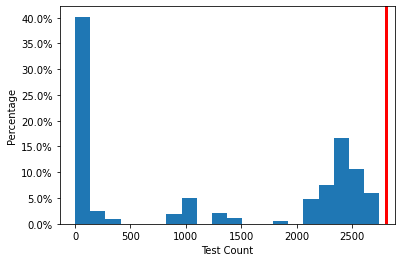

In [3]:
# 3a. Results - compatibility_matrix Python38-PandasLatest

determine_stats_for_pipeline_stage('compatibility_matrix Python38-PandasLatest', 2806)

comprehensive Python38 (433 runs):
  Mean: 'dependency_graph': 2827.13 | 'great_expectations': 6060
  Median: 'dependency_graph': 1152.00 | 'great_expectations': 6060
  Mode: 'dependency_graph': 55.00 | 'great_expectations': 6060



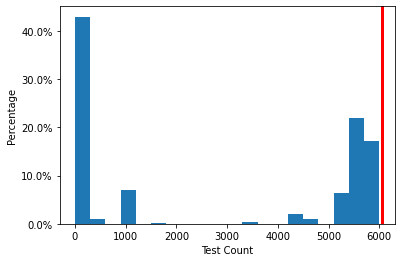

In [4]:
# 3b. Results - comprehensive Python38

determine_stats_for_pipeline_stage('comprehensive Python38', 6060)

mysql (433 runs):
  Mean: 'dependency_graph': 2338.17 | 'great_expectations': 5060
  Median: 'dependency_graph': 1123.00 | 'great_expectations': 5060
  Mode: 'dependency_graph': 55.00 | 'great_expectations': 5060



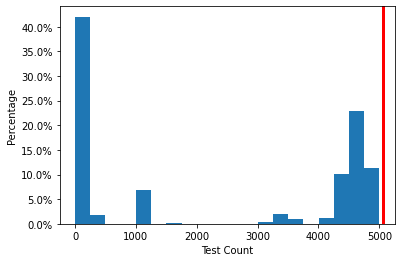

In [5]:
# 3c. Results - mysql (mssql is identical so we only count one to be efficient)

determine_stats_for_pipeline_stage('mysql', 5060)

test_cli (317 runs):
  Mean: 'dependency_graph': 229.53 | 'great_expectations': 454
  Median: 'dependency_graph': 279.00 | 'great_expectations': 454
  Mode: 'dependency_graph': 0.00 | 'great_expectations': 454



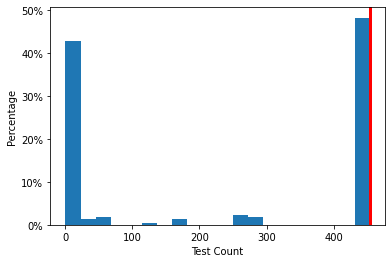

In [6]:
# 3d. Results - test_cli

# We only count instances where this stage is active (hence the reduced number of runs)
determine_stats_for_pipeline_stage('test_cli', 454)